<a href="https://colab.research.google.com/github/mrbane10/machine_translation/blob/main/machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'german-english:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5270047%2F8769986%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T181702Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D06be49769d2574817ca2183d7b3b2ae511ea8cdb7b1cc27750625215e4f1ae6fb5514d73323e81ff125326d5115ed7e101c2f52041c58d22208f245a8147dddf7233ad8a88803bfc83bb7824e99057fe3f20d2fc3b5df264016c5be5b260529f5b558c8c90574635cfbcebe3d51c18930a8d58cf410b71ded47ab560e3596a7161d9596b14b7125eba05438f962a94ade1a147d66959cb22c6a60db28b41ee90977b3f7285ae60b671ea46711d3011c3f1433147837a8e701b4aa6e2dd3111ed4988e1fa07b05f04c99e35b1fac17652d33008e0326cab51c1f666b9556379e6a331eaf3aa416910859ff9f7bec816a4724e118a97d984a03c611ff16ff49d48'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/german-english/deu.txt


In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
def read_text(filename):
        file = open(filename, mode='rt', encoding='utf-8')
        text = file.read()
        file.close()
        return text

In [ ]:
data = read_text("/kaggle/input/german-english/deu.txt")
data[:180]

'Go.\tGeh.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)\nHi.\tHallo!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)\nHi.\t'

In [ ]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
lines=to_lines(data)
lines[:5]

[['Go.',
  'Geh.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
 ['Hi.',
  'Hallo!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
 ['Hi.',
  'Grüß Gott!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
 ['Run!',
  'Lauf!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
 ['Run.',
  'Lauf!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)']]

In [ ]:
deu_eng = array(lines)
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts. Doch wenn wir unsere Mitglieder dazu bringen können, nicht mit Sprachen herumzuexperimentieren, die sie gerade lernen, sondern Sätze in ihrer eigenen Muttersprache beizutragen, dann gelingt 

In [ ]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts. Doch wenn wir unsere Mitglieder dazu bringen können, nicht mit Sprachen herumzuexperimentieren, die sie gerade lernen, sondern Sätze in ihrer eigenen Muttersprache beizutragen, dann gelingt 

In [ ]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [ ]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort However if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'Es ist wohl unmöglich einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts Doch wenn wir unsere Mitglieder dazu bringen können nicht mit Sprachen herumzuexperimentieren die sie gerade lernen sondern Sätze in ihrer eigenen Muttersprache beizutragen dann gelingt es uns vielleicht

In [ ]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

In [ ]:
deu_eng[100:110]

array([['no way', 'das kommt nicht in frage',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2175 (CM) & #444494 (Espi)'],
       ['no way', 'das gibt’s doch nicht',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2175 (CM) & #722128 (Pfirsichbaeumchen)'],
       ['no way', 'ausgeschlossen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2175 (CM) & #1670006 (Pfirsichbaeumchen)'],
       ['no way', 'in keinster weise',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2175 (CM) & #2344583 (Vortarulo)'],
       ['really', 'wirklich',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #373216 (kotobaboke) & #373376 (lilygilder)'],
       ['really', 'echt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #373216 (kotobaboke) & #808911 (Manfredo)'],
       ['really', 'im ernst',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #373216 (kotobaboke) & #937379 (Sudajaengi)'],
       ['thanks', 'danke',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #44

In [ ]:
eng_l = []
deu_l = []
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))


In [ ]:
print(max(eng_l),max(deu_l))

101 76


In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

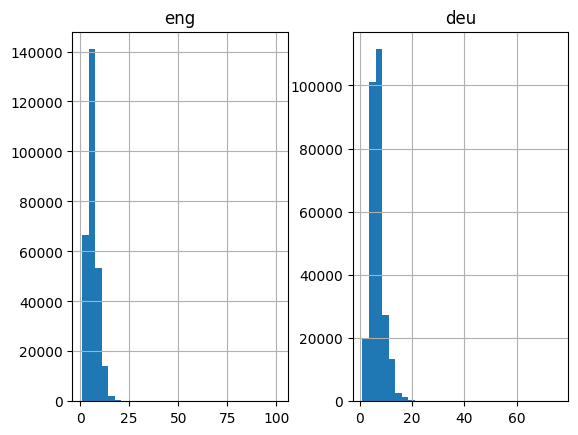

In [ ]:
length_df.hist(bins = 30)
plt.show()

In [ ]:
length_df.shape

(277891, 2)

In [ ]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

In [ ]:
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 18145


In [ ]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

In [ ]:
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 40261


In [ ]:
def encode_sequences(tokenizer, length, lines):
         seq = tokenizer.texts_to_sequences(lines)
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(deu_eng, test_size=0.2, random_state = 1)

In [ ]:
x_train = encode_sequences(deu_tokenizer, max(deu_l), train[:, 1])
y_train = encode_sequences(eng_tokenizer, max(eng_l), train[:, 0])

In [ ]:
x_test = encode_sequences(deu_tokenizer, max(deu_l), test[:, 1])
y_test = encode_sequences(eng_tokenizer, max(eng_l), test[:, 0])

In [ ]:
#defing the model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
model = define_model(deu_vocab_size, eng_vocab_size, max(deu_l), max(eng_l), 512)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = '/kaggle/working/model.h1.23_jan_19.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(x_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
                    epochs=30, batch_size=256, validation_split=0.2, callbacks=[checkpoint], verbose=1)

Epoch 1/30
